In this notebook, we will learn how to apply linear models, such as Linear Regression, Ridge, LASSO and Elastic Net on our Lending Club dataset, to predict the interest rate for each individual customer. 

Some features such as loan status and grade are response-related, indicating that they are highly related to the interest rate. Since we might not be able to get those features before predicting interest rate, they should not be included in the model. 

Before training model, we should 

* get all categorical variables dummied
* split data into train and test
* standardization

We introduce how to use AIC, MAE and RMSE to select models. Here the models are very simple, so we fine tune both Ridge, LASSO and Elastic Net. The only hyperparameter we tune here is $\alpha$. You could choose a wide range of values, but we suggest smaller ones as a beginning.

To get the candidate $\alpha$ within a range of say $[10^{-6},10^{-3}]$, linearly pick some values in this interval is a way, but it's not the optimal one. A better way to choose the candidates consists of three steps.

1. Take the log10 of minimum and maximum value of this interval. Here the range becomes $[-6,-3]$.
2. Uniformly choose a fixed number of values within $[-6,-3]$.
3. Each $\alpha$ is equal to $10^r$, where r is the value chosen from step 2.

In this way, you will be able to avoid the scale problem. We use this method to get $\alpha$ candidates in both Ridge, Lasso and Elastic Net. In addition, we also use Gradient Boosting model (will be taught in the next phase) to predict interest rate. You will find that a complex model will easily beat linear models. 

At last, we provide feature importances of our best model. Conclusion and Interpretation are given. 

In [33]:
# Some important packages to import

import pandas as pd
pd.set_option('display.max_columns', None) # you can see all the columns of a dataframe table
 
import numpy as np
import math
import time
from scipy import stats
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot") # ggplot in R

import warnings
warnings.filterwarnings('ignore')

# Read Cleaned Data

In [15]:
loan_model = pd.read_csv('../data/LoanStats_model.csv')

In [16]:
loan_model.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,delinq_2yrs,mths_since_last_delinq,pub_rec,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,settlement_amount,settlement_percentage,settlement_term,is_hardship,annual_inc_new,verification_status_new,dti_new,revol_bal_new,chargeoff_within_12_mths_new,collections_12_mths_ex_med_new,inq_last_6mths_new,mort_acc_new,num_rev_accts_new,open_acc_new,open_act_il_new,earliest_cr_line_new,il_util_2
0,10000.0,10000.0,10000.0,60 months,14.07%,233.05,C,C3,teacher,4 years,RENT,Mar-2018,Current,n,major_purchase,Major purchase,341xx,FL,0.0,32.0,0.0,34.0,w,9035.79,9035.79,1897.19,1897.19,964.21,932.98,0.0,0.0,0.0,Dec-2018,233.05,Jan-2019,Dec-2018,Individual,0.0,0.0,93913.0,0.0,0.0,0.0,54.0,93206.0,0.0,1.0,707.0,111.0,4500.0,0.0,0.0,0.0,1.0,5524.0,3793.0,15.7,0.0,161.0,88.0,18.0,18.0,18.0,18.0,14.0,1.0,1.0,2.0,4.0,30.0,2.0,1.0,17.0,0.0,0.0,0.0,43.8,0.0,0.0,0.0,84930.0,93913.0,4500.0,80430.0,N,Cash,N,0.0,0.0,0.0,True,42000.0,Source Verified,24.69,707.0,0.0,0.0,0.0,0.0,4.0,17.0,15.0,2000,115.884620
1,2600.0,2600.0,2600.0,36 months,7.96%,81.43,A,A5,minority,3 years,MORTGAGE,Mar-2018,Current,n,other,Other,481xx,MI,0.0,0.0,0.0,9.0,w,2074.45,2074.45,649.14,649.14,525.55,123.59,0.0,0.0,0.0,Dec-2018,81.43,Jan-2019,Dec-2018,Individual,0.0,0.0,241067.0,0.0,0.0,0.0,34.0,56811.0,0.0,1.0,7283.0,56.0,15800.0,0.0,0.0,0.0,1.0,30133.0,588.0,94.4,0.0,79.0,64.0,19.0,19.0,45.0,6.0,0.0,2.0,4.0,2.0,2.0,3.0,5.0,4.0,8.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,259780.0,68587.0,10500.0,62185.0,N,Cash,N,0.0,0.0,0.0,True,62000.0,Not Verified,19.61,11776.0,0.0,0.0,0.0,1.0,5.0,8.0,2.0,2010,91.358045
2,10000.0,10000.0,10000.0,36 months,6.07%,304.54,A,A2,director,10+ years,OWN,Mar-2018,Current,n,house,Home buying,117xx,NY,0.0,0.0,0.0,25.0,w,7932.01,7932.01,2429.58,2429.58,2067.99,361.59,0.0,0.0,0.0,Dec-2018,304.54,Jan-2019,Dec-2018,Individual,0.0,0.0,318464.0,0.0,0.0,3.0,16.0,10051.0,0.0,2.0,3634.0,17.0,60900.0,1.0,1.0,0.0,5.0,28951.0,42115.0,14.1,0.0,68.0,288.0,17.0,16.0,17.0,16.0,0.0,2.0,2.0,5.0,9.0,4.0,9.0,2.0,12.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,434276.0,16936.0,49000.0,37376.0,N,Cash,N,0.0,0.0,0.0,True,175000.0,Source Verified,4.94,6885.0,0.0,0.0,0.0,5.0,16.0,12.0,2.0,1990,26.891588
3,10000.0,10000.0,10000.0,36 months,7.96%,313.18,A,A5,assistant,2 years,RENT,Mar-2018,Current,n,credit_card,Credit card refinancing,606xx,IL,0.0,0.0,0.0,19.0,w,7878.77,7878.77,2596.60,2596.60,2121.23,475.37,0.0,0.0,0.0,Dec-2018,413.18,Jan-2019,Dec-2018,Individual,0.0,0.0,150009.0,0.0,0.0,0.0,46.0,138429.0,0.0,2.0,3826.0,43.0,26800.0,0.0,1.0,1.0,2.0,13637.0,2161.0,70.4,0.0,119.0,160.0,16.0,16.0,38.0,2.0,0.0,2.0,7.0,2.0,4.0,4.0,10.0,7.0,12.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,148048.0,150009.0,7300.0,121248.0,N,Cash,N,0.0,0.0,0.0,True,85000.0,Not Verified,7.67,11580.0,0.0,0.0,0.0,0.0,15.0,12.0,2.0,2000,114.170131
4,11200.0,11200.0,11200.0,60 months,30.79%,367.82,G,G1,minority,< 1 year,RENT,Ma

In [17]:
loan_model.shape

(107864, 104)

# Feature Transformation

## Target: interest rate

First, we convert int_rate into corresponding numerical value. 

In [19]:
loan_model['int_rate'] = loan_model['int_rate'].apply(lambda x: float(x[:-1]))

In [20]:
loan_model['int_rate']

0         14.07
1          7.96
2          6.07
3          7.96
4         30.79
          ...  
107859    12.62
107860    10.91
107861    14.08
107862    10.42
107863    13.59
Name: int_rate, Length: 107864, dtype: float64

## Categorical with Multiple Levels

Let's see how many levels are there for each categorical variable.

In [22]:
for f in loan_model:
    if loan_model[f].dtype == 'object':
        print (f, len(loan_model[f].value_counts()))

term 2
grade 7
sub_grade 35
emp_title 21
emp_length 12
home_ownership 4
issue_d 3
loan_status 7
pymnt_plan 2
purpose 13
title 12
zip_code 878
addr_state 50
initial_list_status 2
last_pymnt_d 13
next_pymnt_d 4
last_credit_pull_d 14
application_type 2
hardship_flag 2
disbursement_method 2
debt_settlement_flag 2
verification_status_new 3


### sub_grade

It has a strong correlation with feature "grade". To reduce multicollinearity, we remove sub_grade.

In [23]:
loan_model['grade'].value_counts()

B    32482
C    28747
A    26769
D    15377
E     3691
F      682
G      116
Name: grade, dtype: int64

In [24]:
loan_model['sub_grade'].value_counts()

B5    6974
B1    6933
B2    6759
C1    6458
A4    6198
B3    5924
B4    5892
C3    5787
C2    5761
A3    5688
C4    5669
A5    5321
C5    5072
A2    5052
A1    4510
D1    3479
D2    3329
D3    3164
D4    2796
D5    2609
E3     863
E5     838
E2     805
E4     732
E1     453
F1     397
G1     102
F3      79
F2      78
F4      65
F5      63
G4       5
G2       5
G3       3
G5       1
Name: sub_grade, dtype: int64

In [25]:
loan_model.drop(['sub_grade'], axis=1, inplace=True)

### zip_code

The `zip_code` variable has too many levels. To solve this problem, we choose first and last character of its original zip code as current one. 

<img src="./test/zip_code_map.png">

In [27]:
loan_model['zip_code'] = loan_model['zip_code'].apply(lambda x: x[0]+x[-1])

In [28]:
loan_model['zip_code']

0         3x
1         4x
2         1x
3         6x
4         0x
          ..
107859    8x
107860    0x
107861    6x
107862    4x
107863    9x
Name: zip_code, Length: 107864, dtype: object

### addr_state

It is not important, as we already have some location-based features. So we just remove it.

In [29]:
loan_model.drop(['addr_state'], axis=1, inplace=True)

# Correlations

## Heatmap

Let's first see the correlation coefficients and heatmap of all the numerical variables. This will provide you some information about the relationship between numerical variables and target.

In [31]:
loan_model.select_dtypes(include = [np.number]).corr()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,delinq_2yrs,mths_since_last_delinq,pub_rec,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,settlement_amount,settlement_percentage,settlement_term,annual_inc_new,dti_new,revol_bal_new,chargeoff_within_12_mths_new,collections_12_mths_ex_med_new,inq_last_6mths_new,mort_acc_new,num_rev_accts_new,open_acc_new,open_act_il_new,earliest_cr_line_new,il_util_2
loan_amnt,1.000000,1.000000,0.999996,0.037881,0.944979,-0.013004,-0.016864,-0.025419,0.172971,0.801115,0.801110,0.579662,0.579705,0.450842,0.739698,0.057821,0.041884,0.041720,0.212768,0.005306,-0.000079,0.271245,-0.014553,0.002467,0.017933,-0.006691,0.132781,-0.039910,-0.028338,0.339710,-0.004151,0.316523,-0.012940,0.073728,0.020509,0.004664,0.197486,0.202179,0.035869,0.006636,0.117852,0.131832,0.039059,0.018661,0.021791,-0.011821,-0.044290,0.160101,0.122367,0.192245,0.181499,0.079324,0.138969,0.121099,0.157185,0.004671,-0.021429,-0.016271,0.075004,0.020036,-0.054831,0.016497,0.300428,0.239842,0.332264,0.188916,0.006759,-0.012553,-0.008596,0.323905,0.003811,0.336893,-0.014097,-0.024859,-0.008785,0.202099,0.151776,0.168342,0.036794,-0.120566,-0.008088
funded_amnt,1.000000,1.000000,0.999996,0.037881,0.944979,-0.013004,-0.016864,-0.025419,0.172971,0.801115,0.801110,0.579662,0.579705,0.450842,0.739698,0.057821,0.041884,0.041720,0.212768,0.005306,-0.000079,0.271245,-0.014553,0.002467,0.017933,-0.006691,0.132781,-0.039910,-0.028338,0.339710,-0.004151,0.316523,-0.012940,0.073728,0.020509,0.004664,0.197486,0.202179,0.035869,0.006636,0.117852,0.131832,0.039059,0.018661,0.021791,-0.011821,-0.044290,0.160101,0.122367,0.192245,0.181499,0.079324,0.138969,0.121099,0.157185,0.004671,-0.021429,-0.016271,0.075004,0.020036,-0.054831,0.016497,0.300428,0.239842,0.332264,0.188916,0.006759,-0.012553,-0.008596,0.323905,0.003811,0.336893,-0.014097,-0.024859,-0.008785,0.202099,0.151776,0.168342,0.036794,-0.120566,-0.008088
funded_amnt_inv,0.999996,0.999996,1.000000,0.038022,0.944876,-0.013028,-0.016905,-0.025473,0.172951,0.801153,0.801154,0.579608,0.579656,0.450768,0.739780,0.057822,0.041906,0.041741,0.212762,0.005313,-0.000079,0.271279,-0.014585,0.002467,0.017940,-0.006696,0.132782,-0.039957,-0.028408,0.339732,-0.004160,0.316546,-0.012942,0.073743,0.020470,0.004610,0.197523,0.202224,0.035860,0.006638,0.117861,0.131869,0.039105,0.018693,0.021835,-0.011788,-0.044313,0.160055,0.122310,0.192216,0.181463,0.079336,0.138926,0.121048,0.157160,0.004678,-0.021437,-0.016311,0.075047,0.020047,-0.054889,0.016476,0.300466,0.239845,0.332297,0.188923,0.006768,-0.012543,-0.008588,0.323927,0.003788,0.336904,-0.014088,-0.024873,-0.008824,0.202130,0.151731,0.168316,0.036804,-0.120599,-0.008087
int_rate,0.037881,0.037881,0.038022,1.000000,0.068077,0.100710,0.044938,0.049774,-0.046057,0.045003,0.045106,0.046887,0.046990,-0.054262,0.495689,0.054283,0.047076,0.045856,0.045299,0.008118,0.006936,-0.080775,0.105117,0.124403,0.129494,-0.072593,0.042569,0.085210,0.091570,-0.039730,0.357212,-0.224442,0.128484,0.004079,0.136068,0.128719,-0.077943,-0.341267,0.354577,0.000649,-0.046130,-0.136061,-0.066952,-0.084320,-0.055607,-0.088018,0.068531,0.031531,0.090398,-0.071885,

In [34]:
# get correlation of all numerical variables
correlation = loan_model.select_dtypes(include = [np.number]).corr()
print(correlation['int_rate'].sort_values(ascending = False))

int_rate                1.000000
total_rec_int           0.495689
all_util                0.357212
bc_util                 0.354577
percent_bc_gt_75        0.344463
                          ...   
tot_hi_cred_lim        -0.130786
mo_sin_old_rev_tl_op   -0.136061
total_rev_hi_lim       -0.224442
total_bc_limit         -0.267028
bc_open_to_buy         -0.341267
Name: int_rate, Length: 81, dtype: float64


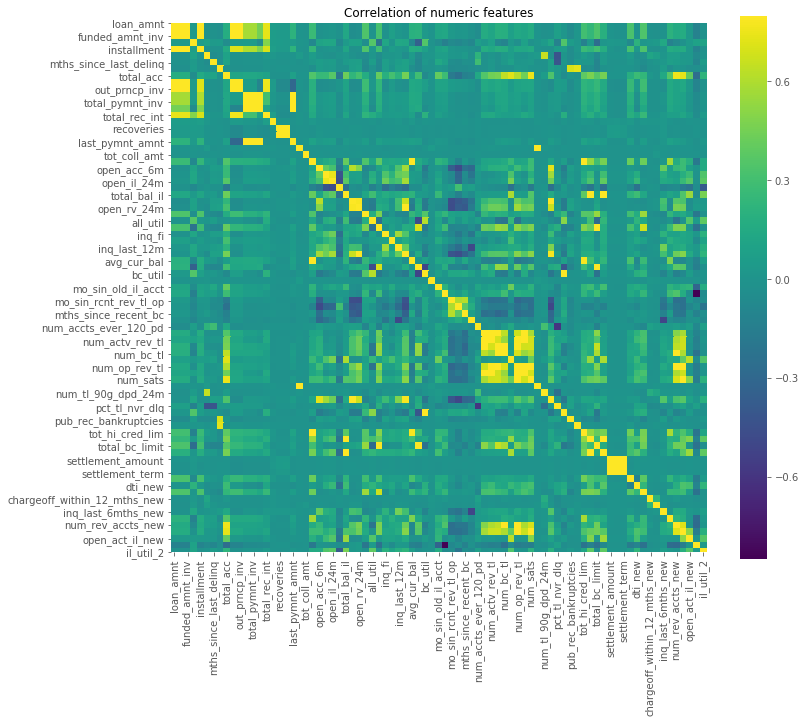

In [35]:
# heatmap in seaborn
plt.figure(figsize = (12,10))
plt.title('Correlation of numeric features',size=12)
sns.heatmap(correlation, square = True, vmax = 0.8, cmap = 'viridis')
plt.show()


## Boxplot

Second, let's see the boxplot. This will give you some insights about the relationship between categorical variables and the target.

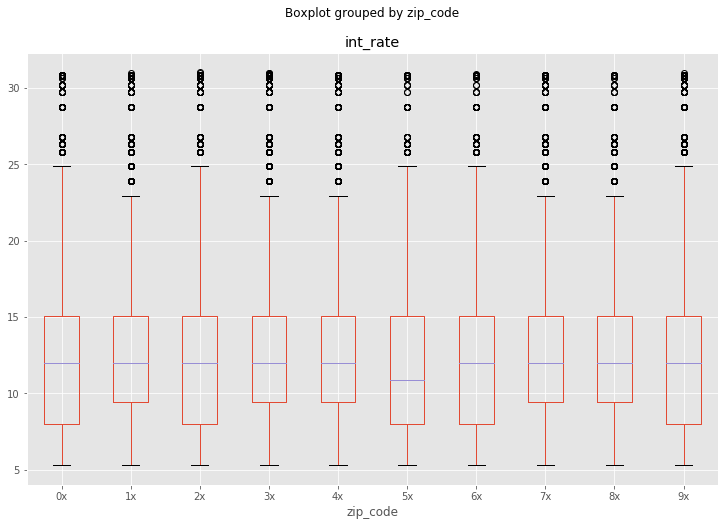

In [14]:
# boxplot of interest rate grouped by zip code
loan_model.boxplot(column='int_rate', by='zip_code', figsize=(12,8))
plt.show()

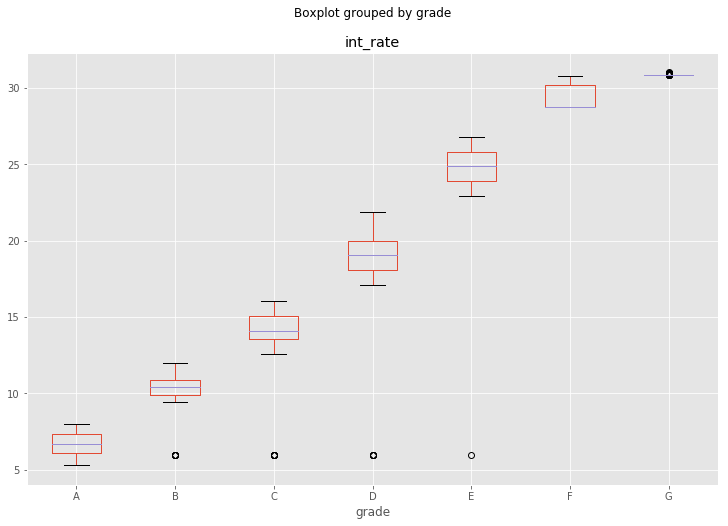

In [15]:
# group by grade
loan_model.boxplot(column='int_rate', by='grade', figsize=(12,8))
plt.show()

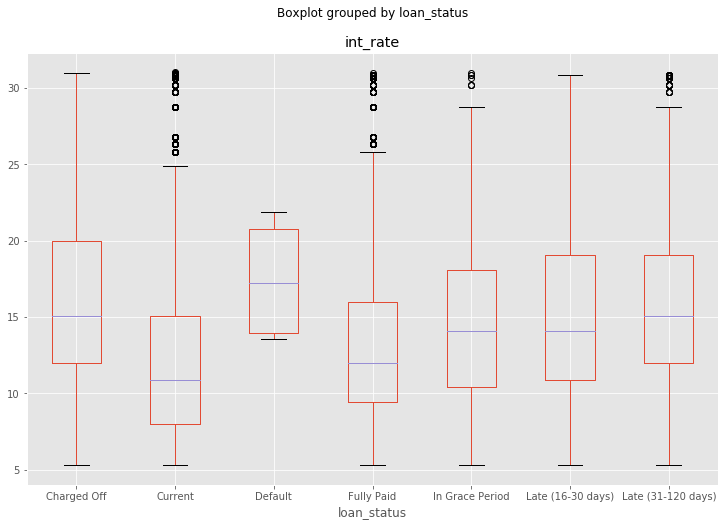

In [36]:
# grouped by loan status
loan_model.boxplot(column='int_rate', by='loan_status', figsize=(12,8))
plt.show()

We should exclude other response-related features that might have extremely high correlation with interest rate. 

In [37]:
loan_model.drop(['loan_status','grade'], axis=1, inplace=True)

# Model Training

## Get dummy

In [39]:
dummy = []
for col in loan_model:
    if loan_model[col].dtype =="object":
        dummy.append(col)

In [40]:
# extract categorical variables
dummy_columns = [x for x in loan_model if loan_model[x].dtype == 'object']

In [44]:
len(dummy_columns)

18

In [45]:
# before dummy
print (loan_model.shape)

# get dummies
loan_model = pd.get_dummies(loan_model, columns = dummy_columns)

# after dummy
print (loan_model.shape)

(107864, 100)
(107864, 205)


## Split train and test

1. cross validation 用来干什么？

2. cross validation vs grid search?

Cross validation 
grid search

max_depth[1,2,3,4], learning_rate[0.1,0.2]

k-fold k = 10


train -> 10 

10 rmse 


train -> train, valid 80%

: 10份

: 9份 train 1 份valid


test 20% -> 验证model

cross validation 用来干什么？
1.避免overfitting
2.调参 hyperparameter alpha


1-9 份 train model, 0 valid(test) model 
0-8 traiin model, 9 valid(test) model


In [48]:
x = loan_model[loan_model.columns.difference(['int_rate'])]
y = loan_model['int_rate'].values

# Split data into train and test (80% & 20%)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state = 42)


## Standardization vs Normalization

1.when standardization and normalization

- 当模型是距离base的情况

- linear regression, 加正则的这种

fit_transform vs transform

In [49]:
from sklearn.preprocessing import StandardScaler

# initialize a scaler object
scaler = StandardScaler()

# transform training set
x_train_std = scaler.fit_transform(x_train)

# the same transform for test set
x_test_std = scaler.transform(x_test)

In [50]:
# transform whole dataset 
X = scaler.fit_transform(x)

## Modeling

In this section, we propose four linear models: Linear Regression, Ridge Regression, Lasso Regression and Elastic Net. We use **cross validation** to tune the hyperparameter for each model (except Linear Regression, since it has no hyperparameter). That is, for each linear model, we derive an optimal set of hyperparameters. To evaluate the optimal model, we choose average RMSE score from cross validation.

In [54]:
# some necessary packages
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [51]:
# Function to evaluate the model using AIC with sum of squared error
def model_evaluation(model, x, y, cv):
    
    kf = KFold(n_splits = cv)
    AIC = 0
    rmse = 0
    mae = 0
    for train_index, validate_index in kf.split(x):
        
        # split to training and validation set
        x_train, x_validate = x[train_index], x[validate_index]
        y_train, y_validate = y[train_index], y[validate_index]
        
        # fit current model
        model.fit(x_train, y_train)
        # predict on validation set
        y_pred = model.predict(x_validate)
        # calculate sse
        sse = np.sum((y_pred - y_validate)**2)
        # number of observations
        n = len(x_train)
        # number of existing features
        k = len([x for x in model.coef_ if x != 0])
        
        # aic
        AIC += 2 * k - 2 * np.log(sse)
        # rmse
        rmse += np.sqrt(np.mean((y_pred - y_validate)**2))
        # mae 
        mae += np.mean(abs(y_pred - y_validate))
        
    # return average score among all validation sets
    return AIC / cv, rmse / cv, mae / cv

### Model Selection

In [55]:
# initialize a model object
import time
LinearReg = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
RidgeReg = Ridge(alpha = 0.1)
LassoReg = Lasso(alpha = 0.001)
ElasticnetReg = ElasticNet(alpha = 0.001, l1_ratio = 0.5)

res_dict = {}
for model in [LinearReg, RidgeReg, LassoReg, ElasticnetReg]:
    print ("Training...", model)
    start = time.time()
    aic, rmse, mae = model_evaluation(model, x_train_std, y_train, 10)
    end = time.time()
    diff = end-start
    print ("Running time is %.2f seconds"%diff)
    print ("Running time is {}seconds".format(diff))
    print ("================================================================")
    res_dict[model] = [round(aic,4), round(rmse,4), round(mae,4), diff]

Training... LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Running time is 17.84 seconds
Running time is 17.836257934570312seconds
Training... Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Running time is 4.15 seconds
Running time is 4.147579193115234seconds
Training... Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Running time is 192.98 seconds
Running time is 192.98257088661194seconds
Training... ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Running time is 282.42 seconds
Running time is 282.4222729206085seconds


In [26]:
df = pd.DataFrame(res_dict).T
df.columns = ["aic", "rmse", "mae", "time"]
df

,aic,rmse,mae,time
"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,\n normalize=False)",386.4700,2.3422,1.7343,6.561022
"Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",384.4693,2.3426,1.7339,1.898296
"Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",325.4531,2.3522,1.7420,55.539544
"ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",345.8526,2.3524,1.7423,79.300141


### Ridge Regression

Use [RidgeCV](https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.RidgeCV.html) function in sklearn.



In [ ]:
[0.01,0.02,...,0.1]

In [33]:
np.random.seed(42)

# candidate values of alpha
alphas_ridge = sorted([10**r for r in np.random.uniform(-6,-3,size=100)])

# initialize a model object
RidgeReg = RidgeCV(alphas = alphas_ridge, store_cv_values=True)

# train model
RidgeReg.fit(x_train_std, y_train)

# get optimal alpha 
rmse_cv_ridge = np.sqrt(RidgeReg.cv_values_.mean(axis = 0))
optimal_alpha_ridge = RidgeReg.alpha_

print ("The optimal value of alpha in Ridge Regression: ", optimal_alpha_ridge)

The optimal value of alpha in Ridge Regression:  9.717775305059627e-05


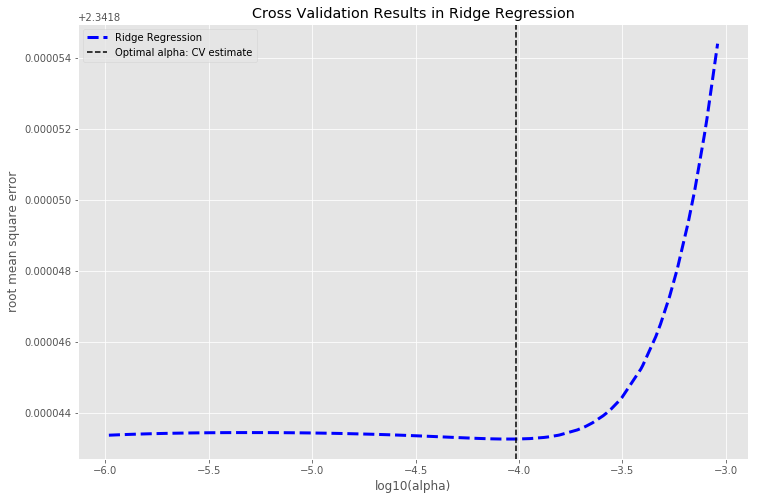

In [34]:
# plot root mean square error with the change of alpha
plt.figure(figsize=(12,8))
plt.plot(np.log10(alphas_ridge), rmse_cv_ridge, '--', color='b',
             linewidth=3, label='Ridge Regression')
plt.axvline(np.log10(optimal_alpha_ridge), linestyle='--', color='k',
        label='Optimal alpha: CV estimate')
plt.xlabel('log10(alpha)')
plt.ylabel('root mean square error')
plt.title('Cross Validation Results in Ridge Regression')
plt.legend()
plt.show()

### LASSO Regression

The [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) method in sklearn will help you tune hyperparameters by your own. Since it will run a long time, we comment these code here. If you are interested in hand-tuning for LASSO, you may uncomment the code and run it.



In [41]:
# np.random.seed(42)

# # Hands on tunning
# alphas_lasso = sorted([10**r for r in np.random.uniform(-9,-6,size=10)])
# rmse_lasso = []

# for alpha in alphas_lasso:
#     rmse = np.mean(np.sqrt(-cross_val_score(Lasso(alpha = alpha, random_state=42), 
#                                               x_train_std, 
#                                               y_train, 
#                                               scoring = "neg_mean_squared_error", 
#                                               cv = 3)))
#     rmse_lasso.append(rmse)

In [42]:
# plt.figure(figsize=(12,8))
# plt.plot(np.log10(alphas), rmse_lasso, 'k',
#              linewidth=2, label='Average across folds')
# plt.xlabel('log10(alpha)')
# plt.ylabel('root mean square error')
# plt.title('Cross Validation Results in Lasso Regression by hand')
# plt.legend()
# plt.show()

Alternatively, we can use [LassoCV](https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.LassoCV.html) to tune hyperparameter $\alpha$, which is more efficient than hand tuning.



In [63]:
np.random.seed(42)

# LassoCV
alphas = sorted([10**r for r in np.random.uniform(-10,-5,size=500)])
# initialize a model object
LassoReg = LassoCV(alphas = alphas, random_state=42, verbose=True, n_jobs=12)
# train model
LassoReg.fit(x_train_std, y_train)

# print out optimal alpha 
rmse_cv_lasso = np.sqrt(LassoReg.mse_path_.mean(axis = -1))
alphas_lasso = LassoReg.alphas_
optimal_alpha_lasso = LassoReg.alpha_
print ("The optimal value of alpha in Lasso Regression: ", optimal_alpha_lasso)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

The optimal value of alpha in Lasso Regression:  6.199100007802271e-09


In [64]:
# check for 0 coefficients
LassoReg.coef_[LassoReg.coef_==0]

array([-0.,  0.,  0.])

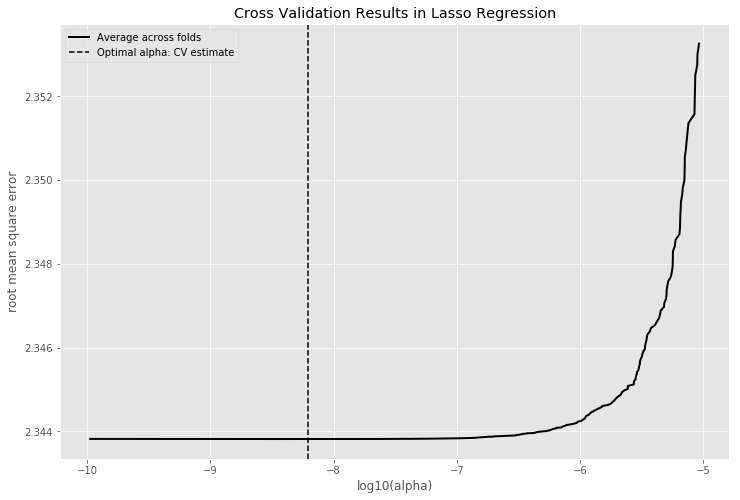

In [65]:
plt.figure(figsize=(12,8))
plt.plot(np.log10(alphas_lasso), rmse_cv_lasso, 'k',
             linewidth=2, label='Average across folds')
plt.axvline(np.log10(optimal_alpha_lasso), linestyle='--', color='k',
        label='Optimal alpha: CV estimate')
plt.xlabel('log10(alpha)')
plt.ylabel('root mean square error')
plt.title('Cross Validation Results in Lasso Regression')
plt.legend()
plt.show()

[Least Angle Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsCV.html) solves the same problem as the LassoCV object. Unlike the LassoCV, it find the relevant alphas values by itself. In general, because of this property, it will be more stable. However, it is more fragile to heavily multicollinear datasets.

LAR is efficient if only a small number of features are selected compared to the total number, for example if there are very few samples compared to the number of features.

We will not get into details about LAR algorithm. There are some references that you could read through.

* http://statweb.stanford.edu/~tibs/ftp/lars.pdf
* https://scikit-learn.org/0.15/auto_examples/linear_model/plot_lasso_model_selection.html


In [51]:
# LassoLarsCV
from sklearn.linear_model import LassoLarsCV

# initialize a model object
LassoLarsReg = LassoLarsCV(cv = 10)
# train model
LassoLarsReg.fit(x_train_std, y_train)
# optimal alpha
print ("The optimal value of alpha in LAR is: ", LassoLarsReg.alpha_)

The optimal value of alpha in LAR is:  0.0004667054342234034


In [53]:
# R-square
LassoLarsReg.score(x_train_std, y_train)

0.6815159187405389

### Elastic Net

[ElasticNetCV](https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.ElasticNetCV.html).

In [66]:
alphas_elasticnet = sorted([10**r for r in np.random.uniform(-8,-5,size=300)])
ElasticNetReg = ElasticNetCV(alphas = alphas_elasticnet, l1_ratio = 0.5, n_jobs=-1)
# train model
ElasticNetReg.fit(x_train_std, y_train)

# print out optimal alpha 
rmse_cv_elasticnet = np.sqrt(ElasticNetReg.mse_path_.mean(axis = -1))
alphas_elasticnet = ElasticNetReg.alphas_
optimal_alpha_elasticnet = ElasticNetReg.alpha_
print ("The optimal value of alpha in Lasso Regression: ", optimal_alpha_elasticnet)

The optimal value of alpha in Lasso Regression:  1.105691566285647e-08


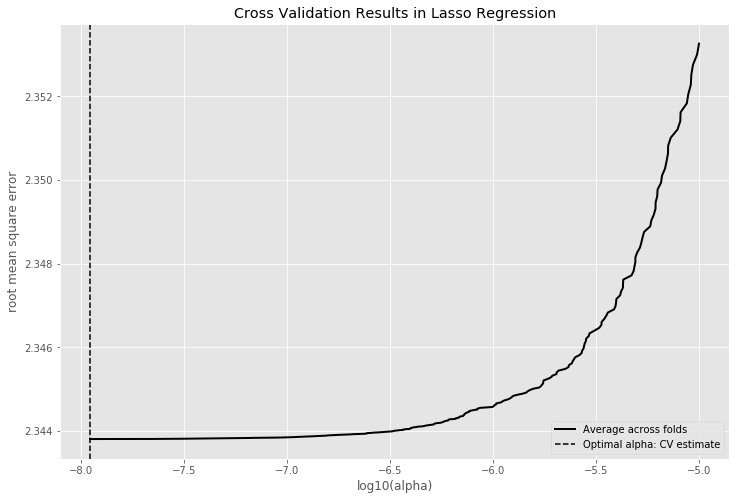

In [67]:
plt.figure(figsize=(12,8))
plt.plot(np.log10(alphas_elasticnet), rmse_cv_elasticnet, 'k',
             linewidth=2, label='Average across folds')
plt.axvline(np.log10(optimal_alpha_elasticnet), linestyle='--', color='k',
        label='Optimal alpha: CV estimate')
plt.xlabel('log10(alpha)')
plt.ylabel('root mean square error')
plt.title('Cross Validation Results in Lasso Regression')
plt.legend()
plt.show()

As we can see, Ridge, LASSO and Elastic Net can derive RMSE around 2.34. However, advanced model such as  [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) with little hyperparameter tune can exceed fine-tune Linear Model easily. 

In [71]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# initialize model
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3)
# fit model
gb.fit(x_train_std, y_train)
# Predict
y_test_pred_boosting = gb.predict(x_test_std)
rmse_test_boosting = np.sqrt(np.mean((y_test - y_test_pred_boosting)**2))
print ("RMSE on test set for Gradient Boosting: ", rmse_test_boosting)

MSE on test set for Gradient Boosting:  1.93169277758473


Let's also apply the four linear models on test set, and calcualte the corresponding RMSEs. We can see that these linear models are somehow underfitting the dataset. This makes sense, because linear model is very simple for lending club data. The target of this project is not to get best regression model with the lowest RMSE or MAE, but to be familiar with Ridge, LASSO and Elastic Net. We will introduce more complicated classification and regression model in next phase.

From the results below, we choose Ridge Regression as the final model.

In [73]:
# Ridge
y_test_pred_ridge = RidgeReg.predict(x_test_std)
rmse_test_ridge = np.sqrt(np.mean((y_test - y_test_pred_ridge)**2))
print ("RMSE on test set for Ridge Regression: ", rmse_test_ridge)

# Lasso
y_test_pred_lasso = LassoReg.predict(x_test_std)
rmse_test_lasso = np.sqrt(np.mean((y_test - y_test_pred_lasso)**2))
print ("RMSE on test set for Lasso Regression: ", rmse_test_lasso)

# Elastic Net
y_test_pred_elasticnet = ElasticNetReg.predict(x_test_std)
rmse_test_elasticnet = np.sqrt(np.mean((y_test - y_test_pred_elasticnet)**2))
print ("RMSE on test set for Elastic Net: ", rmse_test_elasticnet)

RMSE on test set for Ridge Regression:  2.324152749516228
RMSE on test set for Lasso Regression:  2.335152192137883
RMSE on test set for Elastic Net:  2.3351521953984586


# Conclusion and Interpretation

Given the Ridge Regression with the best alpha, we find the coefficients of those features.

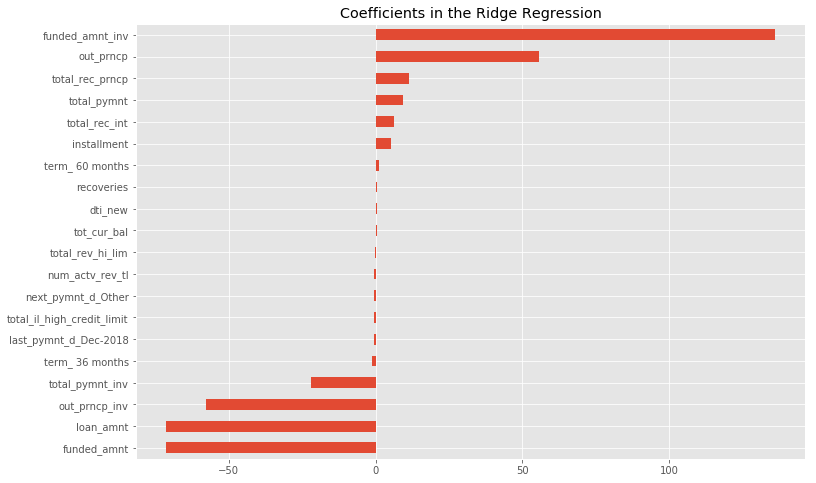

In [75]:
coef = pd.Series(RidgeReg.coef_, index = x.columns)
importance_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.figure(figsize=(12,8))
importance_coef.plot(kind = "barh")
# barh 竖着， kind = bar 横着
plt.title("Coefficients in the Ridge Regression")
plt.show()

* funded_amnt (inv): The total amount committed to that loan at that point in time

* out_prncp (inv): Remaining outstanding principal for total amount funded

* loan_amnt (inv): The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value

